# Imports

In [2]:
import glob
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid", {'axes.grid': False})

# City locations

In [3]:
shp_path = "NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp"
europe = gpd.read_file(shp_path)

id = "NUTS_ID"
country_code = "CNTR_CODE"
europe = europe.set_index(id)
europe.head()

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
NUTS_ID,,,,,,,,,
FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((55.21471 -21.03851, 55.27392 -..."
HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((16.59681 46.47590, 16.85476 46..."
HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((22.12108 48.37831, 22.15531 48.40340..."
AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((19.83100 42.46645, 20.07630 42.55582..."
AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((15.75363 48.85218, 16.29009 48.73395..."


In [4]:
df = pd.DataFrame(
    {'City': ['Athens', 'Rome', 'Berlin', 'Madrid', 'Budapest'],
     'Country': ['Greece', 'Italy', 'Germany', 'Spain', 'Hungary'],
     'Latitude': [37.983829947802185, 41.902791188502164, 52.628511634687065, 40.580893042423405, 47.64689905965705],
     'Longitude': [23.727545763520997, 12.496366775147171, 13.41881818931302, -3.714888490620903, 19.0968668594868]})
cities = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
cities

,City,Country,Latitude,Longitude,geometry
0,Athens,Greece,37.983830,23.727546,POINT (23.72755 37.98383)
1,Rome,Italy,41.902791,12.496367,POINT (12.49637 41.90279)
2,Berlin,Germany,52.628512,13.418818,POINT (13.41882 52.62851)
3,Madrid,Spain,40.580893,-3.714888,POINT (-3.71489 40.58089)
4,Budapest,Hungary,47.646899,19.096867,POINT (19.09687 47.64690)


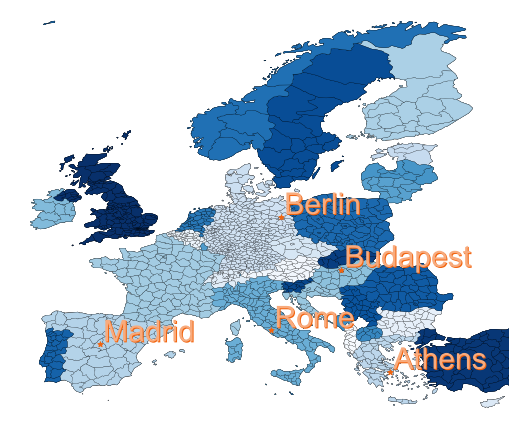

In [35]:
import matplotlib.patheffects as path_effects

f, ax = plt.subplots(1, figsize=(9, 9))

europe.plot(
    column=country_code,
    cmap='Blues',
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

cities.plot(ax=ax, markersize=30, color='#f2630d', marker='*')

for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.City):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='#f8ab7d',
                fontsize=30, path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='#f2630d', alpha=1, offset=(1,-1))])

ax.set_axis_off()
ax.set_xlim(-12.5, 35)
ax.set_ylim(32.5, 72.5)
# plt.axis('equal')
plt.savefig('europe map.png')


# Create dataframe

In [6]:
def create_dataframe(path):
    files = np.array(glob.glob(str(path)))
    files = np.array([Path(file) for file in files])
    files_df = pd.DataFrame(files).rename(columns={0: "filename"})
    # get class name from filename
    files_df['class'] = files_df['filename'].apply(lambda x: x.parent.name)
    # get city name from filename
    files_df['city'] = files_df['filename'].apply(
        lambda x: x.parent.parent.name)

    return files_df

In [7]:
# read image files to dataframe
jpg_path = Path("./extracted-data/imagery/") / Path('*/*/*.jpg')

files_df = create_dataframe(jpg_path)
files_df.head()

,filename,class,city
0,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
1,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
2,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
3,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
4,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"


## Filter dataframe

Remove classes with low number of samples

In [8]:
minimum_samples = 200
low_sample_classes = list(files_df['class'].value_counts()[
                            files_df['class'].value_counts() < minimum_samples].index)

files_df.loc[files_df['class'].isin(low_sample_classes), 'class'] = 'Other'
# files_df.head()

In [9]:
files_df['class'].value_counts()

Other roads and associated land                                9298
Agricultural + Semi-natural areas + Wetlands                   8517
Discontinuous Dense Urban Fabric (S.L.  50% -  80%)            1911
Continuous Urban Fabric (S.L.  80%)                            1778
Industrial, commercial, public, military and private units     1523
Forests                                                        1134
Green urban areas                                               821
Discontinuous Medium Density Urban Fabric (S.L.  30% - 50%)     747
Other                                                           518
Water bodies                                                    469
Railways and associated land                                    464
Sports and leisure facilities                                   451
Fast transit roads and associated land                          309
Discontinuous Low Density Urban Fabric (S.L.  10% - 30%)        260
Name: class, dtype: int64

<AxesSubplot:>

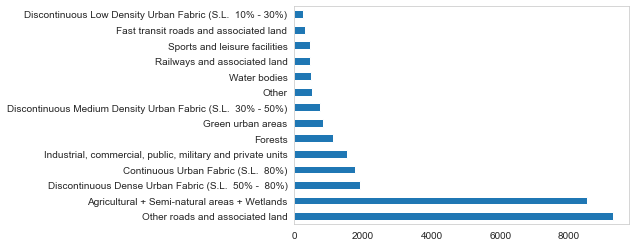

In [10]:
files_df['class'].value_counts().plot(kind='barh')

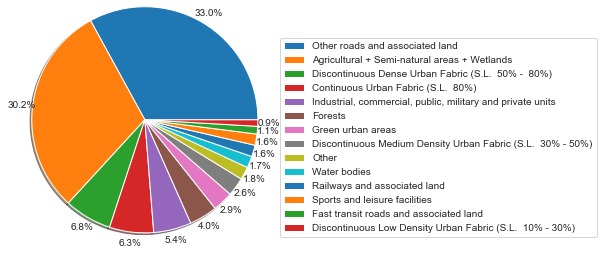

In [11]:
# files_df['class'].value_counts().plot(kind='pie')
ax = files_df['class'].value_counts().plot(
    kind="pie",
    shadow=True,
    legend=True,
    # title='Categories',
    ylabel='',
    labeldistance=None,
    autopct='%1.1f%%',
    pctdistance=1.1,
    rotatelabels=True,
    radius = 1.3
)

ax.legend(bbox_to_anchor=(1.1, 0.9), loc='upper left')
plt.savefig('dataset classes.png')